In [1]:
import sys    
print('Running on Python version: {}'.format(sys.version))


Running on Python version: 3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


The point of this NB is to show that relative to certain models, certain models, some NU error criteria are in conflict with each other.
The way I show this is to optimize a model with all parameters free to vary, while resulting models are compared against only NU error measurement at a time. In this way I show that the parameter sets of non conflicted (compatible) waveform measurements correspond to model parameter sets that are clustered togethor.

Note: on reproducing this environment. This env is supposed to be dependency light, since we are potentially only analysing data, as opposed to generating it. 

# Pickle Data Files
* As publically available at:
* https://osf.io/7xn2m/

The older pickle file contains backend content.
The newer one does not.
neuronunit.model.backend.__init__ is called which attempts to load complex dependencies: pyNN, NEURON etc.
How to stop this from happening? 

I propose a NU version light, with a light __init__ 


Assumptions, the environment for running this notebook was arrived at by building a dedicated docker files.

https://cloud.docker.com/repository/registry-1.docker.io/russelljarvis/nuo



You can run use dockerhub to get the appropriate file, and launch this notebook using Kitematic.

# Import libraries
To keep the standard running version of minimal and memory efficient, not all available packages are loaded by default. In the cell below I import a mixture common python modules, and custom developed modules associated with NeuronUnit (NU) development

In [2]:
import sys    
print('Running on Python version: {}'.format(sys.version))

import numpy as np
import os
import pickle
import pandas as pd
from neuronunit.tests.fi import RheobaseTestP
from neuronunit.optimization.model_parameters import reduced_dict, reduced_cells  
from neuronunit.optimization import optimization_management as om
from sciunit import scores# score_type 

from neuronunit.optimization.data_transport_container import DataTC
from neuronunit.tests.fi import RheobaseTestP# as discovery
from neuronunit.optimization.optimization_management import dtc_to_rheo, format_test, nunit_evaluation
import quantities as pq
from neuronunit.models.reduced import ReducedModel
from neuronunit.optimization.model_parameters import model_params, path_params
LEMS_MODEL_PATH = path_params['model_path']
list_to_frame = []
from neuronunit.tests.fi import RheobaseTestP

    
from IPython.display import HTML, display
import seaborn as sns


Running on Python version: 3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


/opt/conda/lib/python3.5/site-packages/pyNN/neuron/__init__.py:14: UserWarning: mpi4py not available
  warnings.warn("mpi4py not available")


# The Izhiketich model is instanced using some well researched parameter sets.


First lets get the points in parameter space, that Izhikich himself has published about. These points are often used by the open source brain project to establish between model reproducibility. The itial motivating factor for choosing these points as constellations, of all possible parameter space subsets, is that these points where initially tuned and used as best guesses for matching real observed experimental recordings.

In [3]:
explore_param = {k:(np.min(v),np.max(v)) for k,v in reduced_dict.items()}

## Get the experimental Data pertaining to four different classes or neurons, that can constrain models.
Next we get some electro physiology data for four different classes of cells that are very common targets of scientific neuronal modelling. We are interested in finding out what are the most minimal, and detail reduced, low complexity model equations, that are able to satisfy 

Below are some of the data set ID's I used to query neuroelectro.
To save time for the reader, I prepared some data earlier to save time, and saved the data as a pickle, pythons preferred serialisation format.

The interested reader can find some methods for getting cell specific ephys data from neuroelectro in a code file (neuronunit/optimization/get_neab.py) 


In [4]:
purkinje ={"id": 18, "name": "Cerebellum Purkinje cell", "neuron_db_id": 271, "nlex_id": "sao471801888"}
fi_basket = {"id": 65, "name": "Dentate gyrus basket cell", "neuron_db_id": None, "nlex_id": "nlx_cell_100201"}
pvis_cortex = {"id": 111, "name": "Neocortex pyramidal cell layer 5-6", "neuron_db_id": 265, "nlex_id": "nifext_50"}
#This olfactory mitral cell does not have datum about rheobase, current injection values.
olf_mitral = {"id": 129, "name": "Olfactory bulb (main) mitral cell", "neuron_db_id": 267, "nlex_id": "nlx_anat_100201"}
ca1_pyr = {"id": 85, "name": "Hippocampus CA1 pyramidal cell", "neuron_db_id": 258, "nlex_id": "sao830368389"}
pipe = [ fi_basket, ca1_pyr, purkinje,  pvis_cortex]

In [5]:
electro_tests = []
obs_frame = {}
test_frame = {}

from neuronunit.optimization import get_neab
try: 

    electro_path = str(os.getcwd())+'all_tests.p'

    assert os.path.isfile(electro_path) == True
    with open(electro_path,'rb') as f:
        (obs_frame,test_frame) = pickle.load(f)

except:
    for p in pipe:
        p_tests, p_observations = get_neab.get_neuron_criteria(p)
        obs_frame[p["name"]] = p_observations#, p_tests))
        test_frame[p["name"]] = p_tests#, p_tests))
    electro_path = str(os.getcwd())+'all_tests.p'
    with open(electro_path,'wb') as f:
        pickle.dump((obs_frame,test_frame),f)

# Cast the tabulatable data to pandas data frame
There are many among us who prefer potentially tabulatable data to be encoded in pandas data frame.

In [6]:

for k,v in test_frame.items():
    if "olf_mit" not in k:
        obs = obs_frame[k]
        v[0] = RheobaseTestP(obs['Rheobase'])
df = pd.DataFrame.from_dict(obs_frame)
print(test_frame.keys())


dict_keys(['Hippocampus CA1 pyramidal cell', 'Cerebellum Purkinje cell', 'Neocortex pyramidal cell layer 5-6', 'Dentate gyrus basket cell'])


In the data frame below, you can see many different cell types

In [7]:
df

,Cerebellum Purkinje cell,Dentate gyrus basket cell,Hippocampus CA1 pyramidal cell,Neocortex pyramidal cell layer 5-6
Cell Capacitance,"{'mean': 620.2725 pF, 'n': 4, 'std': 261.30303...",NaN,"{'mean': 89.7960714285714 pF, 'n': 14, 'std': ...","{'mean': 150.584166666667 pF, 'n': 12, 'std': ..."
Input Resistance,"{'mean': 142.057692307692 Mohm, 'n': 13, 'std'...","{'mean': 222.475 Mohm, 'n': 4, 'std': 168.2911...","{'mean': 107.080327644332 Mohm, 'n': 113, 'std...","{'mean': 120.672073643411 Mohm, 'n': 86, 'std'..."
Membrane Time Constant,NaN,"{'mean': 13.25 ms, 'n': 2, 'std': 3.25 ms}","{'mean': 24.5021946169772 ms, 'n': 46, 'std': ...","{'mean': 15.7342424242424 ms, 'n': 33, 'std': ..."
Resting membrane potential,"{'mean': -61.5916666666667 mV, 'n': 6, 'std': ...","{'mean': -62.3 mV, 'n': 3, 'std': 4.0472212689...","{'mean': -65.2261863636364 mV, 'n': 110, 'std'...","{'mean': -68.2481434599156 mV, 'n': 79, 'std':..."
Rheobase,"{'mean': 680.794444444444 pA, 'n': 3, 'std': 4...","{'mean': 106.7 pA, 'n': 1, 'std': 0.0 pA}","{'mean': 189.24 pA, 'n': 17, 'std': 287.163664...","{'mean': 213.849583333333 pA, 'n': 32, 'std': ..."
Spike Amplitude,"{'mean': 71.2308333333333 mV, 'n': 6, 'std': 9...","{'mean': 78.6 mV, 'n': 2, 'std': 5.7 mV}","{'mean': 86.364525297619 mV, 'n': 64, 'std': 1...","{'mean': 80.4351020408164 mV, 'n': 49, 'std': ..."
Spike Half-Width,"{'mean': 0.41412962962963 ms, 'n': 9, 'std': 0...","{'mean': 0.9975 ms, 'n': 4, 'std': 0.442175021...","{'mean': 1.31895278450363 ms, 'n': 59, 'std': ...","{'mean': 1.20769387755102 ms, 'n': 49, 'std': ..."
Spike Threshold,"{'mean': -46.8947619047619 mV, 'n': 7, 'std': ...","{'mean': -38.4 mV, 'n': 2, 'std': 3.4 mV}","{'mean': -47.5985714285714 mV, 'n': 70, 'std':...","{'mean': -42.7357232704403 mV, 'n': 53, 'std':..."


In [8]:
df['Hippocampus CA1 pyramidal cell']

# enable R style caching.
#!pip install git+https://github.com/rossant/ipycache
#%load_ext ipycache

Cell Capacitance              {'mean': 89.7960714285714 pF, 'n': 14, 'std': ...
Input Resistance              {'mean': 107.080327644332 Mohm, 'n': 113, 'std...
Membrane Time Constant        {'mean': 24.5021946169772 ms, 'n': 46, 'std': ...
Resting membrane potential    {'mean': -65.2261863636364 mV, 'n': 110, 'std'...
Rheobase                      {'mean': 189.24 pA, 'n': 17, 'std': 287.163664...
Spike Amplitude               {'mean': 86.364525297619 mV, 'n': 64, 'std': 1...
Spike Half-Width              {'mean': 1.31895278450363 ms, 'n': 59, 'std': ...
Spike Threshold               {'mean': -47.5985714285714 mV, 'n': 70, 'std':...
Name: Hippocampus CA1 pyramidal cell, dtype: object

# Tweak Izhikitich equations
with educated guesses based on information that is already encoded in the predefined experimental observations.

In otherwords use information that is readily amenable into hardcoding into equations 

Select out the 'Neocortex pyramidal cell layer 5-6' below, as a target for optimization

In [9]:
free_params = ['a','b','k','c','C','d','vPeak','vr']
hc_ = reduced_cells['RS']
hc_['vr'] = -65.2261863636364
hc_['vPeak'] = hc_['vr'] + 86.364525297619
explore_param['C'] = (hc_['C']-20,hc_['C']+20)
explore_param['vr'] = (hc_['vr']-5,hc_['vr']+5)
#use_test = collections.OrderedDict()
use_test = test_frame["Neocortex pyramidal cell layer 5-6"]

test_opt = {}

with open('data_dump.p','wb') as f:
    pickle.dump(test_opt,f)

In [10]:

use_test[0].observation
print(use_test[0].name)

rtp = RheobaseTestP(use_test[0].observation)
use_test[0] = rtp
print(use_test[0].observation)

RheobaseTestP
{'mean': array(213.849583333333) * pA, 'n': 32, 'std': array(170.452454715608) * pA}


In [11]:
MU = 6
NGEN = 10

import pickle
import numpy as np
print(free_params)
    
import pickle
test_opt = {}
import numpy as np
try:

    with open('multi_dimension_per_single_criteria.p','rb') as f:
        test_opt = pickle.load(f)
except:

    for index,test in enumerate(use_test):

        ga_out, DO = om.run_ga(explore_param,NGEN,[test],free_params=free_params, NSGA = True, MU = MU)

        test_opt[test] = ga_out
        with open('multi_dimension_per_single_criteria.p','wb') as f:
            pickle.dump(test_opt,f)



['a', 'b', 'k', 'c', 'C', 'd', 'vPeak', 'vr']


In [12]:

test_opt.keys()

dict_keys([<neuronunit.tests.fi.RheobaseTestP object at 0x7f7861aa4828>, <neuronunit.tests.waveform.InjectedCurrentAPWidthTest object at 0x7f7861919eb8>, <neuronunit.tests.waveform.InjectedCurrentAPAmplitudeTest object at 0x7f7861645860>, <neuronunit.tests.passive.CapacitanceTest object at 0x7f78620c3d68>, <neuronunit.tests.waveform.InjectedCurrentAPThresholdTest object at 0x7f7862808080>, <neuronunit.tests.passive.InputResistanceTest object at 0x7f7861e8c198>, <neuronunit.tests.passive.TimeConstantTest object at 0x7f78617f3da0>, <neuronunit.tests.passive.RestingPotentialTest object at 0x7f7861cf3eb8>])

{'injected_square_current': {'amplitude': array(99.5625) * pA, 'delay': array(100.0) * ms, 'duration': array(1000.0) * ms}}
1


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


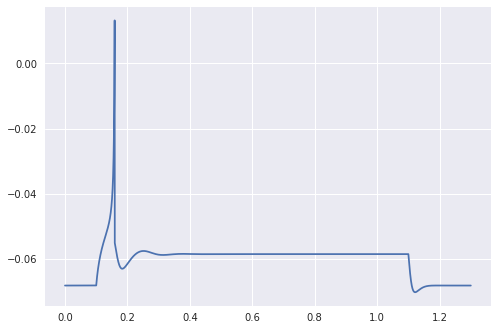

{'injected_square_current': {'amplitude': array(295.6113815307617) * pA, 'delay': array(100.0) * ms, 'duration': array(1000.0) * ms}}
210


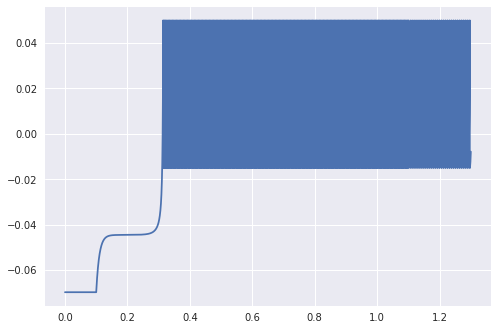

{'injected_square_current': {'amplitude': array(100.18180847167969) * pA, 'delay': array(200.0) * ms, 'duration': array(1000.0) * ms}}
1


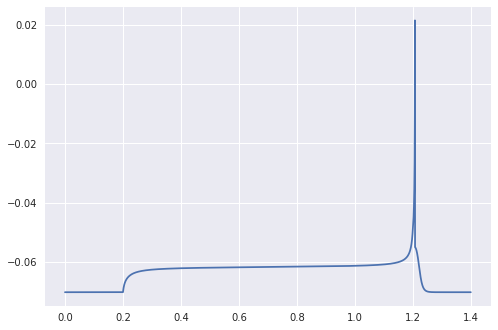

{'injected_square_current': {'amplitude': array(63.878173828125) * pA, 'delay': array(100.0) * ms, 'duration': array(1000.0) * ms}}
1


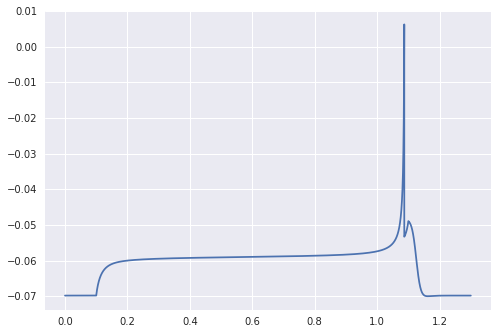

{'injected_square_current': {'amplitude': array(52.875) * pA, 'delay': array(200.0) * ms, 'duration': array(1000.0) * ms}}
1


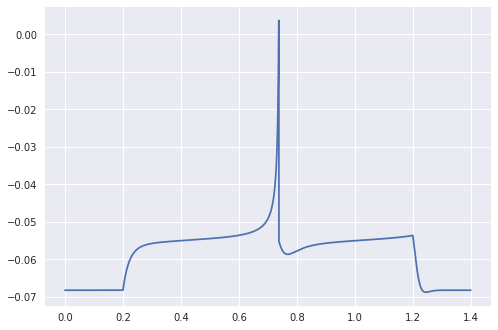

{'injected_square_current': {'amplitude': array(20.311279296875) * pA, 'delay': array(200.0) * ms, 'duration': array(1000.0) * ms}}
1


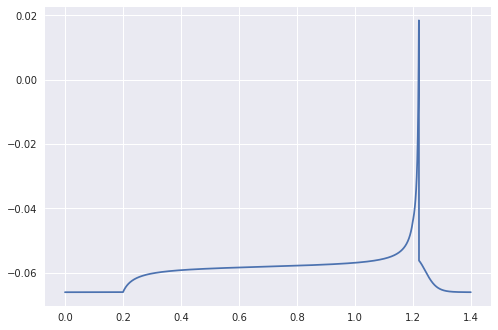

{'injected_square_current': {'amplitude': array(109.9375) * pA, 'delay': array(200.0) * ms, 'duration': array(1000.0) * ms}}
1


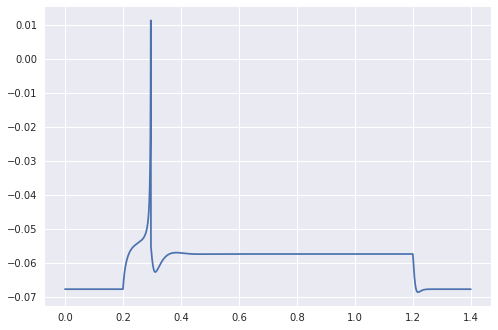

In [13]:
from neuronunit.optimization.optimization_management import mint_generic_model, dtc_to_rheo
import matplotlib.pyplot as plt
#import 
X = []
ranges = {}
best = {}
all_val = {}

for key,value in test_opt.items():
    model = None
    dtc = value['pf'][0].dtc
    model = mint_generic_model(str('RAW'))
    model.set_attrs(dtc.attrs)
    try:
        dtc = dtc_to_rheo(dtc)
        
        dtc.vtest[0]['injected_square_current']['amplitude'] = dtc.rheobase['value']
        dtc.vtest[0]['injected_square_current']['duration'] = 1000*pq.ms

        print(dtc.vtest[0])
        
        model.inject_square_current(dtc.vtest[0])
        #print(dtc.vtest[0],key)
        print(len(model.get_spike_train()))
        plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())#,label='ground truth')
        plt.show()
    except:
        pass


In [14]:

X = []
ranges = {}
best = {}
all_val = {}
for key,value in test_opt.items():
    ranges[key] = {}
    best[key] = {}
    all_val[key] = {}
    for k in value['pf'][0].dtc.attrs.keys():
        
        best[key][k] = value['pf'][0].dtc.attrs[k]

        temp = [i.dtc.attrs[k] for i in value['hof']]

        all_val[key][k] = temp
        ranges[key][k] = (np.min(temp), np.max(temp))
        
data_dump = [best,all_val,ranges]        
pickle.dump(data_dump,open('conflicted_params.p','wb'))


# Visualization 
the amount the amount of freedom to vary left in models optimized per single tests
This plot shows how much freedom does each parameter have, after it has been constrained by individual tests
Tests, with complimentary parameter freedoms, should not be in conflict.
Consistanty 'd' is often unconstrained.

Intermittantly 'c', 'vPeak', and 'C' are.

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


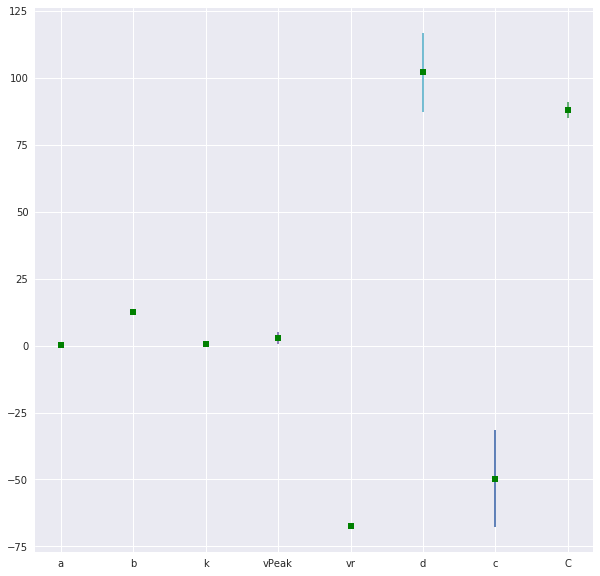

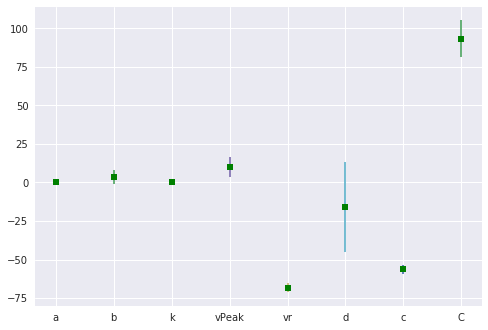

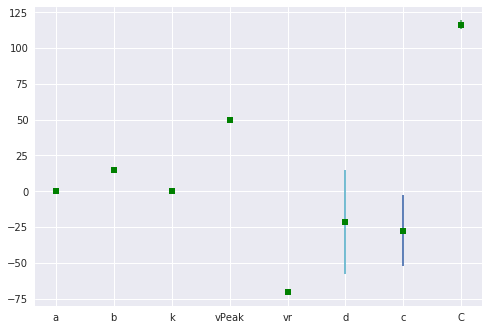

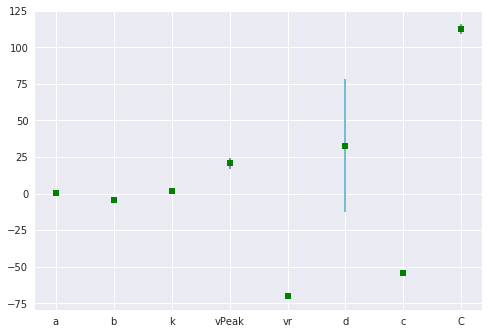

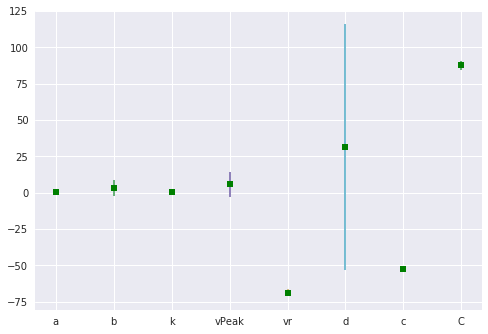

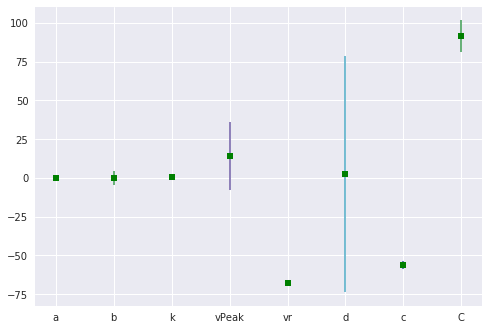

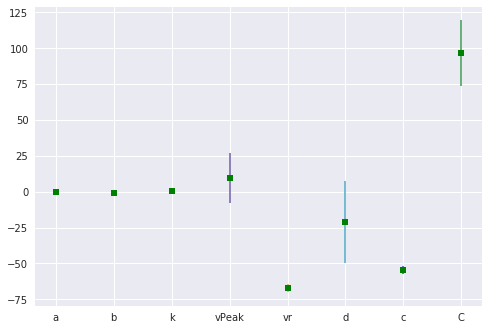

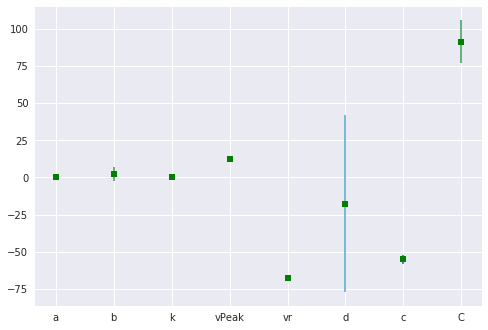

In [15]:
import seaborn as sns
from matplotlib.pyplot import errorbar
import matplotlib.pyplot as plt

fig0,ax0 = plt.subplots(len(test_opt),1,figsize=(10,10))

cnt=0
for key,value in test_opt.items():

    x = 0
    labels = []
    plt.clf()
    for k in value['pf'][0].dtc.attrs.keys():
        
        value = ranges[key][k]

        y = np.mean(value)
        err = max(value)-min(value)
        errorbar(x, y, err, marker='s', mfc='red',
                 mec='green', ms=2, mew=4,label='in '+str(k))
        x+=1
        labels.append(k)
    plt.xticks(np.arange(len(labels)), labels)
    ax0[cnt] = plt
    cnt+=1
    plt.show()



# Visualize the clusters

In [16]:
first_test = all_val[list(all_val.keys())[0]].values()
ft = all_val[list(all_val.keys())[0]]

X = list(first_test)
X_labels = all_val[list(all_val.keys())[0]].keys()

df1 = pd.DataFrame(X)
#df1 = df.T
#X_labels
df1 = pd.DataFrame(X,index=X_labels)


#df1 = df1.T 
df1

,0,1,2,3,4,5
a,0.200000,0.198962,0.200000,0.200000,0.200000,0.200000
b,12.547241,12.463155,12.346548,12.346704,12.547241,12.346704
k,0.580569,0.896644,0.896644,0.896644,0.896644,0.896644
vPeak,1.816482,3.118787,3.908257,3.908257,3.908257,3.908257
vr,-67.272253,-67.272253,-67.272253,-67.272253,-67.272253,-67.272253
d,101.684443,109.438326,102.523588,94.725236,106.922105,102.542865
c,-40.698396,-58.762816,-40.698396,-40.698396,-40.698396,-40.698396
C,86.652769,89.344042,88.669291,89.355227,86.334799,88.500571


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


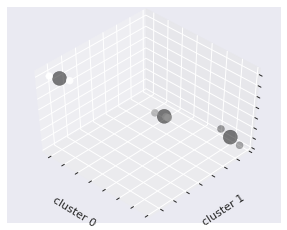

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import datasets
import seaborn as sns; sns.set()  # for plot styling
X = np.array(X)
#X = X.T
est = KMeans(n_clusters=3)

est.fit(X)

y_kmeans = est.predict(X)
centers = est.cluster_centers_

fignum = 1
fig = plt.figure(fignum, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_kmeans, s=50)
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='black', s=200, alpha=0.5);
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('cluster 0')
ax.set_ylabel('cluster 1')
ax.set_zlabel('cluster 2')
fig.savefig('3dCluster.png')

# todo evaluate models at the cluster centre


In [18]:
#for groups in range(0,2):
y_kmeans
#X*.y_kmeans
first_test = test_opt[list(test_opt.keys())[0]].values()
test_names = [t.name for t in test_opt.keys()]
test_classes = [t for t in test_opt.keys()]

grouped_testsn = {}
grouped_tests = {}

for i,k in enumerate(y_kmeans):        
    grouped_testsn[k] = []
    grouped_tests[k] = []
for i,k in enumerate(y_kmeans):        
    grouped_testsn[k].append(test_names[i])
    grouped_tests[k].append(test_classes[i])

print(grouped_tests)    

print(grouped_testsn)

{0: [<neuronunit.tests.passive.InputResistanceTest object at 0x7f7861e8c198>, <neuronunit.tests.passive.RestingPotentialTest object at 0x7f7861cf3eb8>], 1: [<neuronunit.tests.fi.RheobaseTestP object at 0x7f7861aa4828>, <neuronunit.tests.waveform.InjectedCurrentAPWidthTest object at 0x7f7861919eb8>, <neuronunit.tests.waveform.InjectedCurrentAPAmplitudeTest object at 0x7f7861645860>, <neuronunit.tests.passive.CapacitanceTest object at 0x7f78620c3d68>], 2: [<neuronunit.tests.waveform.InjectedCurrentAPThresholdTest object at 0x7f7862808080>, <neuronunit.tests.passive.TimeConstantTest object at 0x7f78617f3da0>]}
{0: ['InputResistanceTest', 'RestingPotentialTest'], 1: ['RheobaseTestP', 'InjectedCurrentAPWidthTest', 'InjectedCurrentAPAmplitudeTest', 'CapacitanceTest'], 2: ['InjectedCurrentAPThresholdTest', 'TimeConstantTest']}


In [ ]:
MU = 6
NGEN = 60

import pickle
import numpy as np
print(free_params)
    
import pickle
test_opt = {}
import numpy as np
try:
    assert 1==2
    with open('clustered_multi_dimension_per_single_criteria.p','rb') as f:
        test_opt = pickle.load(f)
except:

    for key,test in grouped_tests.items():
        tn = grouped_testsn[key]
        
        print(tn)
        ga_out, DO = om.run_ga(explore_param,NGEN,test,free_params=free_params, NSGA = True, MU = MU)
        test_opt[str(tn)] = ga_out
        
        with open('clustered_multi_dimension_per_single_criteria.p','wb') as f:
            pickle.dump(test_opt,f)


['a', 'b', 'k', 'c', 'C', 'd', 'vPeak', 'vr']
['InputResistanceTest', 'RestingPotentialTest']


INFO:__main__:gen	nevals	avg     	std     	min     	max    
1  	6     	0.995683	0.366128	0.428902	1.51191
2  	5     	0.964619	0.398022	0.347598	1.51191


true minimum 0.347598107001


INFO:__main__:3  	6     	0.702512	0.130651	0.533093	0.88351


true minimum 0.347598107001


INFO:__main__:4  	5     	0.503505	0.133246	0.342028	0.680992


true minimum 0.347598107001


INFO:__main__:5  	6     	0.429418	0.114613	0.274183	0.638697


true minimum 0.27418342358


INFO:__main__:6  	5     	0.492573	0.220568	0.228661	0.732631


true minimum 0.27418342358


INFO:__main__:7  	4     	0.277489	0.0883509	0.112674	0.379978


true minimum 0.11267383096


INFO:__main__:8  	6     	0.310674	0.121284 	0.164231	0.485735


true minimum 0.11267383096


INFO:__main__:9  	6     	0.230096	0.143191 	0.116065	0.543643


true minimum 0.11267383096


INFO:__main__:10 	3     	0.168286	0.081908 	0.103376	0.342028


true minimum 0.11267383096


INFO:__main__:11 	4     	0.136974	0.0382334	0.0816452	0.192784


true minimum 0.11267383096


INFO:__main__:12 	5     	0.18271 	0.128201 	0.0463722	0.444397


true minimum 0.0463721764021


INFO:__main__:13 	5     	0.434395	0.267852 	0.0816452	0.933329


true minimum 0.0463721764021


INFO:__main__:14 	6     	0.252617	0.104533 	0.103376 	0.381686


true minimum 0.0463721764021


INFO:__main__:15 	4     	0.225764	0.185632 	0.0463722	0.550893


true minimum 0.0463721764021


INFO:__main__:16 	5     	0.196783	0.148074 	0.0816452	0.500184


true minimum 0.0463721764021


INFO:__main__:17 	6     	0.273787	0.254507 	0.0643857	0.716221


true minimum 0.0463721764021


INFO:__main__:18 	6     	0.523064	0.296399 	0.0326204	0.880757


true minimum 0.0326203886092


INFO:__main__:19 	6     	0.190406	0.136931 	0.0119748	0.410876


true minimum 0.0119747830002


INFO:__main__:20 	4     	0.156797	0.0759472	0.0119748	0.270539


true minimum 0.0119747830002


INFO:__main__:21 	5     	0.343087	0.302838 	0.150225 	1.01004 


true minimum 0.0119747830002


INFO:__main__:22 	6     	0.254314	0.0636273	0.158565 	0.32649 


true minimum 0.0119747830002


INFO:__main__:23 	5     	0.143116	0.101284 	0.0119748	0.31696 


true minimum 0.0119747830002


INFO:__main__:24 	4     	0.154683	0.110841 	0.0119748	0.362421


true minimum 0.0119747830002


INFO:__main__:25 	5     	0.179906	0.126023 	0.0119748	0.347429


true minimum 0.0119747830002


INFO:__main__:26 	6     	0.239133	0.113349 	0.0947898	0.409106


true minimum 0.0119747830002


INFO:__main__:27 	6     	0.204105	0.110503 	0.0119748	0.330901


true minimum 0.0119747830002


INFO:__main__:28 	6     	0.399221	0.0627863	0.305545 	0.494869


true minimum 0.0119747830002


INFO:__main__:29 	6     	0.209918	0.172447 	0.0217478	0.571755


true minimum 0.0119747830002


INFO:__main__:30 	4     	0.130307	0.128064 	0.0119748	0.345725


true minimum 0.0119747830002


INFO:__main__:31 	5     	0.0631377	0.0630681	0.0119748	0.18291 


true minimum 0.0119747830002


INFO:__main__:32 	6     	0.0951829	0.105771 	0.0209563	0.312716


true minimum 0.0119747830002


INFO:__main__:33 	4     	0.160057 	0.126514 	0.0319009	0.405746


true minimum 0.0119747830002


INFO:__main__:34 	6     	0.10794  	0.0927071	0.013034 	0.295896


true minimum 0.0119747830002


INFO:__main__:35 	6     	0.23774  	0.32379  	0.0119607	0.953715


true minimum 0.0119606988649


INFO:__main__:36 	5     	0.202501 	0.184775 	0.0395504	0.543425


true minimum 0.0119606988649


INFO:__main__:37 	6     	0.291502 	0.258125 	0.0425167	0.806932


true minimum 0.0119606988649


INFO:__main__:38 	3     	0.197264 	0.112753 	0.0850921	0.333955


true minimum 0.0119606988649


INFO:__main__:39 	6     	0.162484 	0.0901861	0.0136506	0.295105


true minimum 0.0119606988649


INFO:__main__:40 	6     	0.152575 	0.090115 	0.0527333	0.315314


true minimum 0.0119606988649


INFO:__main__:41 	6     	0.11386  	0.0836437	0.0119606	0.274423


true minimum 0.011960608671


INFO:__main__:42 	6     	0.183913 	0.0781194	0.0872864	0.291797


true minimum 0.011960608671


INFO:__main__:43 	5     	0.208956 	0.125653 	0.0366768	0.390158


true minimum 0.011960608671


INFO:__main__:44 	6     	0.317218 	0.216339 	0.0503392	0.67619 


true minimum 0.011960608671


INFO:__main__:45 	5     	0.308941 	0.159218 	0.0876365	0.610104


true minimum 0.011960608671


INFO:__main__:46 	5     	0.111949 	0.10201  	0.0119607	0.255631


true minimum 0.011960608671


INFO:__main__:47 	5     	0.202208 	0.163062 	0.0119607	0.455652


true minimum 0.011960608671


INFO:__main__:48 	5     	0.120531 	0.0749189	0.0119607	0.217732


true minimum 0.011960608671


INFO:__main__:49 	6     	0.192254 	0.225822 	0.0119607	0.681133


true minimum 0.011960608671


INFO:__main__:50 	6     	0.161964 	0.170641 	0.00658852	0.468389


true minimum 0.0065885207188


INFO:__main__:51 	6     	0.286144 	0.272413 	0.0417375 	0.748322


true minimum 0.0065885207188


INFO:__main__:52 	5     	0.198753 	0.178449 	0.01793   	0.491632


true minimum 0.0065885207188


INFO:__main__:53 	4     	0.220833 	0.169834 	0.00658852	0.454718


true minimum 0.0065885207188


INFO:__main__:54 	6     	0.245128 	0.171609 	0.0126127 	0.498809


true minimum 0.0065885207188


INFO:__main__:55 	5     	0.10055  	0.129202 	0.0125899 	0.383086


true minimum 0.0065885207188


INFO:__main__:56 	6     	0.166951 	0.109431 	0.0287236 	0.332684


true minimum 0.0065885207188


INFO:__main__:57 	5     	0.202674 	0.155061 	0.028723  	0.428354


true minimum 0.0065885207188


INFO:__main__:58 	4     	0.22839  	0.287367 	0.00658852	0.842265


true minimum 0.0065885207188


INFO:__main__:59 	6     	0.238436 	0.126183 	0.0917548 	0.407215


true minimum 0.0065885207188


INFO:__main__:60 	5     	0.171661 	0.161467 	0.0258363 	0.493127


true minimum 0.0065885207188


INFO:__main__:61 	5     	0.375805 	0.325391 	0.0487241 	0.944918


true minimum 0.0065885207188


INFO:__main__:62 	5     	0.160458 	0.103535 	0.00685187	0.259898


true minimum 0.0065885207188


INFO:__main__:63 	6     	0.132403 	0.0734885	0.0149786 	0.233082


true minimum 0.0065885207188


INFO:__main__:64 	5     	0.0613914	0.0523392	0.0124439 	0.165792


true minimum 0.0065885207188


INFO:__main__:65 	6     	0.104016 	0.108762 	0.00656005	0.321579


true minimum 0.00656005234438


INFO:__main__:66 	5     	0.0945892	0.139516 	0.00652086	0.400801


true minimum 0.00656005234438


INFO:__main__:67 	6     	0.325585 	0.163105 	0.0264233 	0.513745


true minimum 0.00656005234438


INFO:__main__:68 	5     	0.192292 	0.181733 	0.00682763	0.494367


true minimum 0.00656005234438


INFO:__main__:69 	2     	0.0918485	0.0792205	0.00652086	0.227615


true minimum 0.00652085624077


INFO:__main__:70 	6     	0.202391 	0.219955 	0.0162358 	0.577392


true minimum 0.00652085624077


INFO:__main__:71 	6     	0.235446 	0.156346 	0.0430803 	0.487584


true minimum 0.00652085624077


INFO:__main__:72 	6     	0.121282 	0.0765494	0.0107101 	0.227239


true minimum 0.00652085624077


INFO:__main__:73 	4     	0.0999009	0.0813076	0.00682763	0.217675


true minimum 0.00652085624077


INFO:__main__:74 	6     	0.154035 	0.116987 	0.0159566 	0.377553


true minimum 0.00652085624077


INFO:__main__:75 	5     	0.085428 	0.110994 	0.00682763	0.32581 


true minimum 0.00652085624077


INFO:__main__:76 	6     	0.0924864	0.0832477	0.0200036 	0.270944


true minimum 0.00652085624077


INFO:__main__:77 	6     	0.272904 	0.248269 	0.0140635 	0.658621


true minimum 0.00652085624077


INFO:__main__:78 	6     	0.227147 	0.148657 	0.0350424 	0.407387


true minimum 0.00652085624077


INFO:__main__:79 	6     	0.184258 	0.195741 	0.0135338 	0.532832


true minimum 0.00652085624077


INFO:__main__:80 	5     	0.206214 	0.221349 	0.0420672 	0.680722


true minimum 0.00652085624077


INFO:__main__:81 	5     	0.20998  	0.148043 	0.0280823 	0.494493


true minimum 0.00652085624077


INFO:__main__:82 	6     	0.117732 	0.144454 	0.00689184	0.411965


true minimum 0.00652085624077


INFO:__main__:83 	6     	0.183957 	0.133983 	0.0122719 	0.365   


true minimum 0.00652085624077


INFO:__main__:84 	6     	0.350205 	0.174837 	0.0262378 	0.507373


true minimum 0.00652085624077


INFO:__main__:85 	5     	0.228675 	0.208238 	0.0262378 	0.521978


true minimum 0.00652085624077


INFO:__main__:86 	5     	0.148086 	0.146953 	0.00670987	0.464738


true minimum 0.00652085624077


INFO:__main__:87 	6     	0.192901 	0.130871 	0.0498948 	0.37412 


true minimum 0.00652085624077


INFO:__main__:88 	6     	0.278543 	0.174815 	0.0163138 	0.568182


true minimum 0.00652085624077


INFO:__main__:89 	6     	0.174871 	0.170509 	0.0104118 	0.514633


true minimum 0.00652085624077


INFO:__main__:90 	6     	0.256602 	0.165871 	0.077302  	0.563584


true minimum 0.00652085624077


INFO:__main__:91 	6     	0.0742318	0.0531156	0.0247852 	0.183625


true minimum 0.00652085624077


INFO:__main__:92 	6     	0.166436 	0.184747 	0.0336173 	0.565227


true minimum 0.00652085624077


INFO:__main__:93 	5     	0.0983017	0.0583255	0.0241268 	0.168834


true minimum 0.00652085624077


INFO:__main__:94 	5     	0.0720719	0.0957206	0.00861014	0.280026


true minimum 0.00652085624077


INFO:__main__:95 	6     	0.126122 	0.150589 	0.0104258 	0.454534


true minimum 0.00652085624077


INFO:__main__:96 	6     	0.0858924	0.0664289	0.0104864 	0.213909


true minimum 0.00652085624077


INFO:__main__:97 	6     	0.178698 	0.187491 	0.00391692	0.531703


true minimum 0.00391691992269


INFO:__main__:98 	6     	0.187911 	0.229285 	0.00519228	0.522182


true minimum 0.00391691992269


INFO:__main__:99 	6     	0.252423 	0.195305 	0.00391688	0.53251 


true minimum 0.00391687562458


INFO:__main__:100	5     	0.0963499	0.0538313	0.0241268 	0.157402


true minimum 0.00391687562458
['RheobaseTestP', 'InjectedCurrentAPWidthTest', 'InjectedCurrentAPAmplitudeTest', 'CapacitanceTest']


/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in exp
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in multiply
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
INFO:__main__:gen	nevals	avg    	std     	min    	max    
1  	6     	2.55369	0.15608 	2.21621	2.66417
2  	5     	2.53726	0.109313	2.3174 	2.67905


true minimum 2.21620906784


INFO:__main__:3  	6     	2.53538	0.183987	2.13901	2.66691


true minimum 2.13900927441


/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in exp
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in multiply
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
INFO:__main__:4  	6     	2.49227	0.131653	2.22385	2.65926


true minimum 2.13900927441


INFO:__main__:5  	4     	2.34271	0.260982	2.0745 	2.82088


true minimum 2.07450310773


INFO:__main__:6  	5     	2.41187	0.237025	2.16135	2.82772


true minimum 2.07450310773


/opt/conda/lib/python3.5/site-packages/deap/tools/crossover.py:333: RuntimeWarning: invalid value encountered in double_scalars
  beta_q = (1.0 / (2.0 - rand * alpha))**(1.0 / (eta + 1))
/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in exp
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in multiply
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
INFO:__main__:7  	6     	2.35574	0.352627	1.9627 	2.87824


true minimum 1.96270122959


INFO:__main__:8  	5     	2.28051	0.329526	1.81332	2.70191


true minimum 1.96270122959


INFO:__main__:9  	3     	2.34489	0.329193	1.81332	2.66881


true minimum 1.96270122959


/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in exp
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in multiply
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
INFO:__main__:10 	5     	2.36004	0.328344	1.80339	2.70176


true minimum 1.8033889339


INFO:__main__:11 	6     	2.35344	0.272551	2.00902	2.72388


true minimum 1.8033889339


INFO:__main__:12 	6     	2.34724	0.309865	1.96395	2.84172


true minimum 1.8033889339


INFO:__main__:13 	5     	2.39065	0.367986	1.87992	2.88687


true minimum 1.8033889339


INFO:__main__:14 	5     	2.45996	0.256644	2.08826	2.82967


true minimum 1.8033889339


INFO:__main__:15 	5     	2.40197	0.237518	2.07746	2.66952


true minimum 1.8033889339


INFO:__main__:16 	6     	2.46931	0.376593	1.75668	2.82267


true minimum 1.75668249371


INFO:__main__:17 	6     	2.64264	0.166058	2.35019	2.80332


true minimum 1.75668249371


INFO:__main__:18 	6     	2.41064	0.423843	1.65769	2.87177


true minimum 1.65768867942


INFO:__main__:19 	4     	2.35712	0.324218	1.99289	2.92911


true minimum 1.65768867942


INFO:__main__:20 	6     	2.60509	0.142941	2.33003	2.7625 


true minimum 1.65768867942


INFO:__main__:21 	6     	2.48063	0.263731	2.11481	2.84484


true minimum 1.65768867942


INFO:__main__:22 	4     	2.38612	0.241743	2.11091	2.77052


true minimum 1.65768867942


INFO:__main__:23 	5     	2.47057	0.183401	2.15517	2.67436


true minimum 1.65768867942


INFO:__main__:24 	6     	2.497  	0.208721	2.24296	2.75856


true minimum 1.65768867942


INFO:__main__:25 	4     	2.36488	0.266708	1.99289	2.74157


true minimum 1.65768867942


INFO:__main__:26 	5     	2.49645	0.397048	1.9021 	2.92848


true minimum 1.65768867942


/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in exp
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in multiply
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
INFO:__main__:27 	6     	2.407  	0.390272	1.88373	2.99652


true minimum 1.65768867942


INFO:__main__:28 	6     	2.40954	0.213137	2.07978	2.74778


true minimum 1.65768867942


/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in exp
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in multiply
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
INFO:__main__:29 	6     	2.28719	0.303878	1.90988	2.72707


true minimum 1.65768867942


INFO:__main__:30 	4     	2.41191	0.200309	2.17256	2.75733


true minimum 1.65768867942


INFO:__main__:31 	6     	2.39168	0.34328 	1.84551	2.79431


true minimum 1.65768867942


INFO:__main__:32 	6     	2.50547	0.236697	2.07035	2.85865


true minimum 1.65768867942


INFO:__main__:33 	6     	2.35263	0.186129	2.14253	2.73521


true minimum 1.65768867942


INFO:__main__:34 	5     	2.29338	0.34431 	1.96584	2.98992


true minimum 1.65768867942


INFO:__main__:35 	5     	2.36425	0.262986	1.86827	2.70716


true minimum 1.65768867942


INFO:__main__:36 	6     	2.485  	0.224206	2.25036	2.81028


true minimum 1.65768867942


INFO:__main__:37 	6     	2.26412	0.407758	1.76452	2.86081


true minimum 1.65768867942


/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in exp
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in multiply
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
INFO:__main__:38 	6     	2.35055	0.268608	2.00987	2.7923 


true minimum 1.65768867942


INFO:__main__:39 	6     	2.47029	0.235617	2.1473 	2.7878 


true minimum 1.65768867942


INFO:__main__:40 	6     	2.19253	0.213719	1.95532	2.60348


true minimum 1.65768867942


/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in exp
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in multiply
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
INFO:__main__:41 	6     	2.15592	0.405287	1.67681	2.92186


true minimum 1.65768867942


/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in exp
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in multiply
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
INFO:__main__:42 	6     	2.60438	0.305654	1.9708 	2.93178


true minimum 1.65768867942


INFO:__main__:43 	4     	2.36254	0.239755	1.95532	2.74157


true minimum 1.65768867942


INFO:__main__:44 	6     	2.25869	0.226268	1.94154	2.62313


true minimum 1.65768867942


/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in exp
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in multiply
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
INFO:__main__:45 	6     	2.4136 	0.20694 	2.02286	2.69644


true minimum 1.65768867942


INFO:__main__:46 	4     	2.30703	0.285118	1.87451	2.58217


true minimum 1.65768867942


INFO:__main__:47 	6     	2.30819	0.407903	1.54115	2.66295


true minimum 1.54114585002


INFO:__main__:48 	6     	2.47408	0.168181	2.26564	2.75941


true minimum 1.54114585002


INFO:__main__:49 	6     	2.39021	0.146195	2.17476	2.5834 


true minimum 1.54114585002


INFO:__main__:50 	6     	2.39504	0.215116	2.03647	2.62604


true minimum 1.54114585002


INFO:__main__:51 	5     	2.35388	0.174093	2.03647	2.507  


true minimum 1.54114585002


INFO:__main__:52 	6     	2.23136	0.400968	1.65716	2.81785


true minimum 1.54114585002


INFO:__main__:53 	6     	2.45863	0.172494	2.22834	2.73871


true minimum 1.54114585002


INFO:__main__:54 	6     	2.2349 	0.343144	1.712  	2.58185


true minimum 1.54114585002


INFO:__main__:55 	6     	2.37471	0.162944	2.17633	2.66313


true minimum 1.54114585002


INFO:__main__:56 	6     	2.39178	0.193895	1.98261	2.60908


true minimum 1.54114585002


INFO:__main__:57 	5     	2.30913	0.212622	1.9826 	2.54017


true minimum 1.54114585002


INFO:__main__:58 	5     	2.24294	0.384859	1.54115	2.69827


true minimum 1.54114585002


INFO:__main__:59 	6     	2.51197	0.207216	2.06402	2.66831


true minimum 1.54114585002


INFO:__main__:60 	4     	2.26631	0.327249	1.65716	2.64306


true minimum 1.54114585002


INFO:__main__:61 	3     	2.28024	0.298737	1.73662	2.64306


true minimum 1.54114585002


INFO:__main__:62 	6     	2.33095	0.261519	1.9721 	2.60135


true minimum 1.54114585002


INFO:__main__:63 	3     	2.20489	0.370367	1.54963	2.72194


true minimum 1.54114585002


INFO:__main__:64 	6     	2.43172	0.23057 	2.01151	2.78353


true minimum 1.54114585002


INFO:__main__:65 	4     	2.21476	0.374075	1.53531	2.55999


true minimum 1.54114585002


INFO:__main__:66 	6     	2.48909	0.204058	2.22746	2.78242


true minimum 1.54114585002


INFO:__main__:67 	5     	2.40801	0.229257	2.07245	2.66181


true minimum 1.54114585002


/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in exp
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in multiply
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
INFO:__main__:68 	6     	2.424  	0.402318	1.69244	2.89845


true minimum 1.54114585002


INFO:__main__:69 	6     	2.3671 	0.170721	2.16758	2.65308


true minimum 1.54114585002


INFO:__main__:70 	5     	2.60109	0.129972	2.37628	2.74839


true minimum 1.54114585002


INFO:__main__:71 	6     	2.42234	0.282171	1.81467	2.6081 


true minimum 1.54114585002


INFO:__main__:72 	5     	2.42219	0.359984	1.81467	2.88251


true minimum 1.54114585002


INFO:__main__:73 	6     	2.34714	0.305471	1.69443	2.6274 


true minimum 1.54114585002


INFO:__main__:74 	6     	2.52339	0.126826	2.34457	2.75747


true minimum 1.54114585002


/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in exp
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in multiply
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
INFO:__main__:75 	5     	2.3174 	0.302996	1.69443	2.61105


true minimum 1.54114585002


INFO:__main__:76 	5     	2.48348	0.101363	2.37628	2.66118


true minimum 1.54114585002


INFO:__main__:77 	5     	2.48029	0.152402	2.24618	2.64645


true minimum 1.54114585002


INFO:__main__:78 	4     	2.28489	0.34909 	1.69793	2.61924


true minimum 1.54114585002


INFO:__main__:79 	5     	2.25085	0.248326	1.80975	2.53155


true minimum 1.54114585002


INFO:__main__:80 	6     	2.38565	0.244214	1.91538	2.63052


true minimum 1.54114585002


/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in exp
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in multiply
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
INFO:__main__:81 	5     	2.33772	0.242927	1.91488	2.61924


true minimum 1.54114585002


INFO:__main__:82 	5     	2.29188	0.353544	1.69443	2.71539


true minimum 1.54114585002


INFO:__main__:83 	4     	2.30943	0.41226 	1.4408 	2.75287


true minimum 1.44080324453


INFO:__main__:84 	6     	2.35038	0.195467	2.13987	2.72013


true minimum 1.44080324453


INFO:__main__:85 	6     	2.59738	0.140069	2.41877	2.82892


true minimum 1.44080324453


INFO:__main__:86 	6     	2.33084	0.237261	1.90207	2.56331


true minimum 1.44080324453


INFO:__main__:87 	6     	2.43639	0.361265	1.94261	2.86489


true minimum 1.44080324453


INFO:__main__:88 	6     	2.09102	0.244578	1.86315	2.57754


true minimum 1.44080324453


INFO:__main__:89 	6     	2.16705	0.279736	1.83891	2.60355


true minimum 1.44080324453


/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in exp
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in multiply
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
INFO:__main__:90 	6     	2.17863	0.287165	1.61804	2.44332


true minimum 1.44080324453


INFO:__main__:91 	6     	2.3527 	0.207635	1.96056	2.65896


true minimum 1.44080324453


INFO:__main__:92 	4     	2.25202	0.253208	1.80809	2.55717


true minimum 1.44080324453


INFO:__main__:93 	5     	2.37436	0.397024	1.79925	2.97828


true minimum 1.44080324453


/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in exp
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in multiply
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
INFO:__main__:94 	6     	2.48656	0.323677	1.8343 	2.81784


true minimum 1.44080324453


INFO:__main__:95 	5     	2.21693	0.194842	1.92734	2.47765


true minimum 1.44080324453


INFO:__main__:96 	6     	2.28592	0.260961	1.79485	2.53279


true minimum 1.44080324453


INFO:__main__:97 	6     	2.35955	0.291073	1.79485	2.69197


true minimum 1.44080324453


INFO:__main__:98 	6     	2.40953	0.266272	1.97353	2.72712


true minimum 1.44080324453


INFO:__main__:99 	6     	2.37171	0.171284	2.19859	2.69304


true minimum 1.44080324453


INFO:__main__:100	6     	2.35573	0.369242	1.91762	2.90308


true minimum 1.44080324453
['InjectedCurrentAPThresholdTest', 'TimeConstantTest']


/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in exp
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
/home/jovyan/neuronunit/neuronunit/tests/passive.py:85: RuntimeWarning: overflow encountered in multiply
  vm_fit[offset:,0] = a * np.exp(-t[offset:]/b) + c
INFO:__main__:gen	nevals	avg    	std      	min    	max    
1  	6     	1.85648	0.112845 	1.60883	1.93263
2  	5     	1.85025	0.0890467	1.7215 	1.93068


true minimum 1.60882566928


INFO:__main__:3  	5     	1.65223	0.366592 	0.871103	1.92252


true minimum 0.871102987326


INFO:__main__:4  	4     	1.59573	0.179171 	1.34206 	1.89756


true minimum 0.871102987326


INFO:__main__:5  	6     	1.39896	0.387644 	0.759318	1.81526


true minimum 0.759317806985


INFO:__main__:6  	6     	1.2204 	0.366197 	0.717125	1.6097 


true minimum 0.717124514134


INFO:__main__:7  	6     	1.0156 	0.279166 	0.634984	1.48843


true minimum 0.634984012989


INFO:__main__:8  	6     	0.850918	0.20488  	0.530998	1.17852


true minimum 0.53099800225


INFO:__main__:9  	6     	0.887004	0.347393 	0.339058	1.44998


true minimum 0.339057708839


INFO:__main__:10 	6     	0.80416 	0.314929 	0.552576	1.44006


true minimum 0.339057708839


INFO:__main__:11 	6     	0.709558	0.363437 	0.0266915	1.25458


true minimum 0.0266915150572


INFO:__main__:12 	6     	0.785938	0.465974 	0.0465117	1.43533


true minimum 0.0266915150572


INFO:__main__:13 	6     	0.814654	0.305059 	0.464785 	1.43763


true minimum 0.0266915150572


INFO:__main__:14 	5     	0.606783	0.540028 	0.0493924	1.76534


true minimum 0.0266915150572


INFO:__main__:15 	6     	0.834159	0.522795 	0.186749 	1.81744


true minimum 0.0266915150572


INFO:__main__:16 	4     	0.723237	0.58431  	0.0465117	1.76508


true minimum 0.0266915150572


INFO:__main__:17 	6     	0.883043	0.545757 	0.302224 	1.66108


true minimum 0.0266915150572


INFO:__main__:18 	6     	0.621804	0.42698  	0.0826769	1.27368


true minimum 0.0266915150572


INFO:__main__:19 	6     	1.10286 	0.433621 	0.541009 	1.82124


true minimum 0.0266915150572


INFO:__main__:20 	4     	0.492163	0.52079  	0.0493924	1.53667


true minimum 0.0266915150572


INFO:__main__:21 	6     	0.372027	0.240793 	0.0875435	0.861542


true minimum 0.0266915150572


INFO:__main__:22 	5     	0.310749	0.238478 	0.0315155	0.663086


true minimum 0.0266915150572


INFO:__main__:23 	6     	0.379455	0.29503  	0.0067972	0.871116


true minimum 0.00679719986223


INFO:__main__:24 	5     	0.287764	0.154917 	0.0465117	0.508432


true minimum 0.00679719986223


INFO:__main__:25 	6     	0.458836	0.172407 	0.173172 	0.71151 


true minimum 0.00679719986223


INFO:__main__:26 	6     	0.61378 	0.568788 	0.0753776	1.76372 


true minimum 0.00679719986223


INFO:__main__:27 	5     	0.500834	0.56017  	0.0067972	1.48252 


true minimum 0.00679719986223


INFO:__main__:28 	5     	0.521319	0.305498 	0.212169 	1.09695 


true minimum 0.00679719986223


INFO:__main__:29 	4     	0.323694	0.218989 	0.129138 	0.773659


true minimum 0.00679719986223


INFO:__main__:30 	5     	0.463549	0.279174 	0.0753776	1.0161  


true minimum 0.00679719986223


INFO:__main__:31 	4     	0.713439	0.537596 	0.0753776	1.57683 


true minimum 0.00679719986223


INFO:__main__:32 	5     	0.720613	0.495947 	0.176184 	1.33781 


true minimum 0.00679719986223


INFO:__main__:33 	4     	0.574652	0.460087 	0.129138 	1.38424 


true minimum 0.00679719986223


INFO:__main__:34 	6     	0.500815	0.259262 	0.238825 	0.955052


true minimum 0.00679719986223


INFO:__main__:35 	6     	0.598301	0.195807 	0.426753 	1.00647 


true minimum 0.00679719986223


INFO:__main__:36 	5     	0.42277 	0.415716 	0.0973705	1.06047 


true minimum 0.00679719986223


INFO:__main__:37 	5     	0.756202	0.489271 	0.242377 	1.4812  


true minimum 0.00679719986223


INFO:__main__:38 	6     	0.664982	0.330095 	0.0777415	1.14224 


true minimum 0.00679719986223


INFO:__main__:39 	6     	0.257979	0.176781 	0.0105814	0.496304


true minimum 0.00679719986223


INFO:__main__:40 	6     	0.681242	0.62252  	0.0142693	1.64495 


true minimum 0.00679719986223


INFO:__main__:41 	6     	0.615693	0.566823 	0.0660146	1.48153 


true minimum 0.00679719986223


INFO:__main__:42 	6     	1.10042 	0.67517  	0.187452 	1.92313 


true minimum 0.00679719986223


INFO:__main__:43 	5     	0.621783	0.387986 	0.0105814	1.01369 


true minimum 0.00679719986223


INFO:__main__:44 	6     	0.53421 	0.36607  	0.0567221	1.04886 


true minimum 0.00679719986223


INFO:__main__:45 	6     	0.68499 	0.268943 	0.278885 	1.06858 


true minimum 0.00679719986223


INFO:__main__:46 	6     	0.871855	0.614026 	0.049583 	1.57192 


true minimum 0.00679719986223


INFO:__main__:47 	4     	0.788943	0.72478  	0.0105814	1.82217 


true minimum 0.00679719986223


INFO:__main__:48 	5     	0.564206	0.380634 	0.106928 	1.12504 


true minimum 0.00679719986223


INFO:__main__:49 	6     	0.593079	0.544406 	0.0126311	1.24726 


true minimum 0.00679719986223


INFO:__main__:50 	5     	0.247509	0.213973 	0.0142693	0.530113


true minimum 0.00679719986223


INFO:__main__:51 	5     	0.444419	0.436479 	0.0105814	1.07282 


true minimum 0.00679719986223


INFO:__main__:52 	6     	0.627593	0.346575 	0.060957 	1.10659 


true minimum 0.00679719986223


INFO:__main__:53 	5     	0.62543 	0.500638 	0.0067972	1.3937  


true minimum 0.00679719986223


INFO:__main__:54 	6     	0.530037	0.44707  	0.0125081	1.31984 


true minimum 0.00679719986223


INFO:__main__:55 	6     	0.190801	0.234538 	0.0168389	0.53086 


true minimum 0.00679719986223


INFO:__main__:56 	6     	0.350954	0.315656 	0.0712529	1.00703 


true minimum 0.00679719986223


INFO:__main__:57 	6     	0.227122	0.138484 	0.05282  	0.486751


true minimum 0.00679719986223


INFO:__main__:58 	5     	0.549372	0.620327 	0.0125081	1.76198 


true minimum 0.00679719986223


INFO:__main__:59 	6     	1.04317 	0.668606 	0.215626 	1.78723 


true minimum 0.00679719986223


INFO:__main__:60 	6     	0.673627	0.530927 	0.0776243	1.65108 


true minimum 0.00679719986223


INFO:__main__:61 	6     	0.503376	0.428148 	0.0268583	1.36917 


true minimum 0.00679719986223


INFO:__main__:62 	4     	0.332466	0.357973 	0.0105814	1.0752  


true minimum 0.00679719986223


INFO:__main__:63 	6     	0.697738	0.579053 	0.0843248	1.72569 


true minimum 0.00679719986223


INFO:__main__:64 	5     	0.493991	0.452055 	0.0242563	1.13516 


true minimum 0.00679719986223


In [20]:
len(centers)
print(centers[0])
print(centers[1])
print(centers[2])


[ 94.16860585  99.39118411  95.59643945  92.04023159  96.62845197
  95.52171796]
[ 3.78607329  4.16938711  4.33786225  4.33790149  4.38803569  4.33790149]
[-53.98532468 -63.01753445 -53.98532468 -53.98532468 -53.98532468
 -53.98532468]


In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.columns
#finalDf = pd.concat([principalDf, df[['target']]], axis = 1)

Index(['principal component 1', 'principal component 2'], dtype='object')

In [22]:
principalDf

,principal component 1,principal component 2
0,-29.189379,-1.782634
1,0.763205,-0.942639
2,-27.610221,-1.789846
3,-21.292533,-1.188633
4,-194.383172,-6.723945
5,222.733360,-2.556531
6,-137.164813,11.298365
7,186.143553,3.685863


In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df['a'], df['b'], df['C']], axis = 1)
finalDf.columns

KeyError: 'a'

In [ ]:
finalDf

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['a', 'b', 'C']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
pca.explained_variance_ratio_

In [ ]:
with open('data_dump.p','rb') as f:
    test_opt = pickle.load(f)

In [ ]:
test_opt

In [ ]:
import seaborn as sns
from matplotlib.pyplot import errorbar
import matplotlib.pyplot as plt

fig0,ax0 = plt.subplots(dim,dim,figsize=(10,10))
plt.figure(num=None, figsize=(11, 11), dpi=80, facecolor='w', edgecolor='k')

for v in test_opt.values():
    x = 0
    labels = []
    plt.clf()
    for k_,v_ in v['ranges'].items(): 
        value = v_

        y = np.mean(value)
        err = max(value)-min(value)
        errorbar(x, y, err, marker='s', mfc='red',
                 mec='green', ms=2, mew=4,label='in '+str(k_))
        x+=1
        labels.append(k_)
    plt.xticks(np.arange(len(labels)), labels)
    ax0[i] = plt

plt.show()


# the parameter 'd' only seems important
# C does not have to be too precise within a range.

I consider the final gene populations for each of the eight tests. I compute the variance in each of the converged populations, I see that variance is low in many of the gene populations.

When all variables are used to optomize only against one set of parameters, you expect their would be high variance in parameters, that don't matter much with respect to that error criteria (you expect redundancy of solutions).

I compute std on errors over all the tests in order to estimate how amenable the problem is to multiobjective optimization.

In [ ]:
from neuronunit.models.reduced import ReducedModel
from neuronunit.optimization.model_parameters import model_params, path_params
LEMS_MODEL_PATH = path_params['model_path']
import quantities as pq
plt.figure(num=None, figsize=(11, 11), dpi=80, facecolor='w', edgecolor='k')

for k,v in test_opt.items():    
    model = ReducedModel(LEMS_MODEL_PATH, name= str('vanilla'), backend=('RAW'))
    model.attrs = v['out']['pf'][1].dtc.attrs
    print(str(k), v['out']['pf'][1].dtc.get_ss())#fitness)
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] =v['out']['pf'][1].rheobase['value']*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 100.0*pq.ms
    DURATION = 1000.0*pq.ms
    iparams['injected_square_current']['delay'] = DELAY
    iparams['injected_square_current']['duration'] = int(DURATION)

    model.inject_square_current(iparams)

    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential(),label=str(k))
    plt.legend()
plt.show()


In [ ]:

DO.seed_pop = npcl['pf'][0:MU]
npcl, DO = om.run_ga(explore_param,10,reduced_tests,free_params=free_params,hc = hc, NSGA = False, MU = MU, seed_pop = DO.seed_pop)


In [ ]:
attrs_here = npcl['hardened'][0][0].attrs
attrs_here.update(hc)
attrs_here
scores = npcl['hof'][0].dtc.scores
print(scores)

In [ ]:
#
use_test = test_frame["Neocortex pyramidal cell layer 5-6"]
reduced_tests = [use_test[0], use_test[-1], use_test[len(use_test)-1]]
bigger_tests = use_test[1:-2]
bigger_tests.insert(0,use_test[0])

In [ ]:
#bigger_tests = bigger_tests[-1::]
print(bigger_tests)

In [ ]:
DO.seed_pop = npcl['hof'][0:MU]
reduced_tests = [use_test[0], use_test[-1], use_test[len(use_test)-1]]
npcl, DO = om.run_ga(explore_param,10,bigger_tests,free_params=free_params,hc = hc, NSGA = False, MU = MU)#, seed_pop = DO.seed_pop)


In [ ]:
print(npcl['hardened'][0][0].attrs)
print(npcl['hardened'][0][0].scores)
print(npcl['pf'][0].fitness.values)
print(npcl['hof'][0].dtc.scores)

#for t in use_test:
#    print(t.name)
    
    
pop

# From the scores printed above, it looks like certain error criteria, are in conflict with each other.

Tests, that are amenable to co-optimization appear to be:
* Width test
* Input resistance tets
* Resting Potential Test,
* Capicitance test.
* Time constant

Tests/criteria that seem in compatible with the above include: 
* Rheobase, 
* InjectedCurrentAPThresholdTest
* InjectedCurrentAPAmplitudeTest

Therefore a reduced set of lists is made to check if the bottom three are at least amenable to optimization togethor.

In [ ]:
from sklearn.cluster import KMeans
est = KMeans(n_clusters=2)
est.fit(X)
y_kmeans = est.predict(X)

centers = est.cluster_centers_

fig = plt.figure(fignum,figsize=(4,3))
ax = Axes3D(fig,rect=[0,0,.95,1],elav=48,azim=134)
ax.scatter(X[:,0],X[:,1],X[:,2],c=y_kmeans,s=50),
ax.scatter(centres[:,0],centres[:,1],centres[:,2],c='black',s=200,alpha=0.5)

In [ ]:

print(reduced_tests)
print(bigger_tests)

DO.seed_pop = npcl['pf'][0:MU]
npcl, DO = om.run_ga(explore_param,10,reduced_tests,free_params=free_params,hc = hc, NSGA = True, MU = 12)#, seed_pop = DO.seed_pop)


In [ ]:
import pickle
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from neuronunit.optimization.optimization_management import wave_measure
from neuronunit.models.reduced import ReducedModel
from neuronunit.optimization.model_parameters import model_params, path_params
LEMS_MODEL_PATH = path_params['model_path']
import neuronunit.optimization as opt
import quantities as pq
fig = plt.figure()

plt.clf()

from neuronunit.optimization.data_transport_container import DataTC
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
for i in npcl['pf'][0:2]:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] =i.dtc.rheobase
    model = None
    model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
    model.set_attrs(i.dtc.attrs)

    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 100.0*pq.ms
    DURATION = 1000.0*pq.ms
    iparams['injected_square_current']['delay'] = DELAY
    iparams['injected_square_current']['duration'] = int(DURATION)
    model.inject_square_current(iparams)
    n_spikes = len(model.get_spike_train())
    if n_spikes:
        print(n_spikes)
        #print(i[0].scores['RheobaseTestP']*pq.pA)
        plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())#,label='ground truth')
        plt.legend()

#gca().set_axis_off()
#subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#            hspace = 0, wspace = 0)
#margins(0,0)
#gca().xaxis.set_major_locator(NullLocator())
#gca().yaxis.set_major_locator(NullLocator())

plt.subplots_adjust(left=0.0, right=1.0, top=0.9, bottom=0.1)
fig.tight_layout()
plt.show()

fig.savefig("single_trace.png", bbox_inches = 'tight',
    pad_inches = 0)


In [ ]:
import pickle
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot


from neuronunit.models.reduced import ReducedModel
from neuronunit.optimization.model_parameters import model_params, path_params
LEMS_MODEL_PATH = path_params['model_path']
import neuronunit.optimization as opt
import quantities as pq
fig = plt.figure()

plt.clf()

from neuronunit.optimization.data_transport_container import DataTC
for i in npcl['hardened']:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = i[0].rheobase
    model = None
    model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
    model.set_attrs(i[0].attrs)

    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 100.0*pq.ms
    DURATION = 1000.0*pq.ms
    iparams['injected_square_current']['delay'] = DELAY
    iparams['injected_square_current']['duration'] = int(DURATION)
    model.inject_square_current(iparams)
    n_spikes = len(model.get_spike_train())
    if n_spikes:
        print(n_spikes)
        print(i[0].scores['RheobaseTestP']*pq.pA)
        plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())#,label='ground truth')
        plt.legend()

#gca().set_axis_off()
#subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#            hspace = 0, wspace = 0)
#margins(0,0)
#gca().xaxis.set_major_locator(NullLocator())
#gca().yaxis.set_major_locator(NullLocator())

plt.subplots_adjust(left=0.0, right=1.0, top=0.9, bottom=0.1)
fig.tight_layout()
plt.show()

fig.savefig("single_trace.png", bbox_inches = 'tight',
    pad_inches = 0)


'''
hc = {}

#free_params = ['c','k']
for k,v in explore_param.items():
    if k not in free_params:
        hc[k] = v
constants = npcl['hardened'][0][0].attrs
hc.update(constants) 
npcl, _ = om.run_ga(explore_param,20,test_frame["Neocortex pyramidal cell layer 5-6"],free_params=free_params,hc = hc, NSGA = True)
'''

In [ ]:

free_params = ['a','b','k']#vt','c','k','d']#,'vt','k','c','C']#,'C'] # this can only be odd numbers.

##
# Use information that is available
##
hc = reduced_cells['RS']

hc['vr'] = -65.2261863636364

hc['vPeak'] = hc['vr'] + 86.364525297619
hc['C'] = 89.7960714285714
hc.pop('a',0)
hc.pop('b',0)
hc.pop('k',0)
hc.pop('c',0)
hc.pop('d',0)
        
use_test = test_frame["Neocortex pyramidal cell layer 5-6"]
#DO.seed_pop = npcl['pf']
#ga_out = DO.run(max_ngen = 15)


In [ ]:
'''
import pandas
    
try:
    ne_raw = pandas.read_csv('article_ephys_metadata_curated.csv', delimiter='\t')
    !ls -ltr *.csv
except:
    !wget https://neuroelectro.org/static/src/article_ephys_metadata_curated.csv
    ne_raw = pandas.read_csv('article_ephys_metadata_curated.csv', delimiter='\t')

blah = ne_raw[ne_raw['NeuronName'].str.match('Hippocampus CA1 pyramidal cell')]
#ne_raw['NeuronName']
#ne_raw['cell\ capacitance']
#blah = ne_raw[ne_raw['NeuronName'].str.match('Hippocampus CA1 pyramidal cell')]

print([i for i in blah.columns])
#rint(blah['rheobase'])
#print(blah)
#for i in ne_raw.columns:#['NeuronName']:
#    print(i)

#ne_raw['NeuronName'][85]
#blah = ne_raw[ne_raw['TableID'].str.match('85')]
#ne_raw['n'] = 84
#here = ne_raw[ne_raw['Index']==85]
here = ne_raw[ne_raw['TableID']==18]

print(here['rheo_raw'])
#!wget https://neuroelectro.org/apica/1/n/
'''

In [ ]:
ca1 = ne_raw[ne_raw['NeuronName'].str.match('Hippocampus CA1 pyramidal cell')]
ca1['rheo']

In [ ]:

    
test_frame["Dentate gyrus basket cell"][0].observation['std'] = test_frame["Dentate gyrus basket cell"][0].observation['mean']
for t in test_frame["Dentate gyrus basket cell"]:
    print(t.name)

    print(t.observation)
    


'''
Inibitory Neuron
This can't pass the Rheobase test
'''    

In [ ]:

from neuronunit.optimization import optimization_management as om
import pickle

free_params = ['a','vr','b','vt','vPeak','c','k']
for k,v in explore_param.items():
    if k not in free_params:
        hc[k] = v
use_test = test_frame["Dentate gyrus basket cell"]
bcell, _ = om.run_ga(explore_param,20,use_test,free_params=free_params,hc = hc, NSGA = True, MU = 4)


In [ ]:

    
#test_frame["Dentate gyrus basket cell"][0].observation['std'] = test_frame["Dentate gyrus basket cell"][0].observation['mean']
for t in test_frame["Hippocampus CA1 pyramidal cell"]:
    print(t.name)

    print(t.observation)

In [ ]:
use_test = test_frame["Hippocampus CA1 pyramidal cell"]
bcell, _ = om.run_ga(explore_param,20,use_test,free_params=free_params,hc = hc, NSGA = True, MU = 10)


In [ ]:
import pickle
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuronunit.models.reduced import ReducedModel
from neuronunit.optimization.model_parameters import model_params, path_params
LEMS_MODEL_PATH = path_params['model_path']
import neuronunit.optimization as opt
import quantities as pq
fig = plt.figure()

plt.clf()

from neuronunit.optimization.data_transport_container import DataTC
for i in bcell['hardened'][0:6]:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] =i[0].rheobase
    model = None
    model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
    model.set_attrs(i[0].attrs)

    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 100.0*pq.ms
    DURATION = 1000.0*pq.ms
    iparams['injected_square_current']['delay'] = DELAY
    iparams['injected_square_current']['duration'] = int(DURATION)
    model.inject_square_current(iparams)
    n_spikes = len(model.get_spike_train())
    if n_spikes:
        print(n_spikes)
        print(i[0].scores['RheobaseTestP']*pq.pA)
        plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())#,label='ground truth')
        plt.legend()

#gca().set_axis_off()
#subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#            hspace = 0, wspace = 0)
#margins(0,0)
#gca().xaxis.set_major_locator(NullLocator())
#gca().yaxis.set_major_locator(NullLocator())

plt.subplots_adjust(left=0.0, right=1.0, top=0.9, bottom=0.1)
fig.tight_layout()
plt.show()

fig.savefig("single_trace.png", bbox_inches = 'tight',
    pad_inches = 0)


In [ ]:
use_test = test_frame["Hippocampus CA1 pyramidal cell"]
bcell, _ = om.run_ga(explore_param,20,use_test,free_params=free_params,hc = hc, NSGA = True, MU = 10)


# This cell is in markdown, but it won't be later.
Later optimize a whole heap of cells in a loop.

try:
    import pickle
    with open('data_dump.p','rb') as f:
        test_opt = pickle.load(f)
except:
    MU = 12
    NGEN = 25
    cnt = 1
    for t in use_test:        
        if cnt==len(use_test):
            MU = 12
            NGEN = 20

            npcl, DO = om.run_ga(explore_param,NGEN,[t],free_params=free_params, NSGA = True, MU = MU)
        else:

            npcl, DO = om.run_ga(explore_param,NGEN,[t],free_params=free_params, NSGA = True, MU = MU)

        test_opt[str(t)] =  {'out':npcl}

        ranges = {}
        stds = npcl['pop'][0].dtc.attrs
        for k in npcl['pop'][0].dtc.attrs.keys():    
            stds[k] = []
            ranges[k] = []


        for i in npcl['pop'][::5]:
            for k,v in i.dtc.attrs.items():
                stds[k].append(v)
                ranges[k].append(v)

        for k in npcl['pop'][0].dtc.attrs.keys():
            ranges[k] = (np.min(ranges[k][1::]),np.max(ranges[k][1::]))

            stds[k] = np.std(stds[k][1::])
        test_opt[str(t)]['stds'] = stds 
        test_opt[str(t)]['ranges'] = ranges 

        cnt+=1
    
    with open('data_dump.p','wb') as f:
        pickle.dump(test_opt,f)
       